In [1]:
!pip install timm

In [2]:
import os, os.path
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
from torchvision import datasets, models, transforms
import timm

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

Module: Load_data

In [3]:
def get_class_distribution(dataset_obj, idx2class):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict

In [4]:
def load_data(hieroglyph_directory_path, batch_size=20, num_workers=0):
    train_dir = os.path.join(hieroglyph_directory_path, 'train/')
    test_dir = os.path.join(hieroglyph_directory_path, 'test/')

    classes = []

    for filename in os.listdir(train_dir):
        if filename == '.DS_Store':
            pass
        else:
            classes.append(filename)

    classes.sort()

    # print("Our classes:", classes)
    # print(len(classes))

    data_transform = transforms.Compose([transforms.ToTensor(),
                                              transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                              transforms.RandomRotation(degrees=(-10, 10)),
                                              transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                              transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                              contrast=(1, 1.5),
                                                                                              saturation=(1, 1.5),
                                                                                              hue=(0, 0.5))]),
                                              transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                        inplace=False),
                                              transforms.Resize((75, 75)),
                                              transforms.Normalize((0.5,), (0.5,))])

    train_data = datasets.ImageFolder(train_dir, transform=data_transform)
    test_data = datasets.ImageFolder(test_dir, transform=data_transform)

    # print('Num training images: ', len(train_data))
    # print('Num test images: ', len(test_data))

    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               num_workers=num_workers, shuffle=True)
    
    # WeightedRandomSampler for test loader
    idx2class_test = {v: k for k, v in test_data.class_to_idx.items()}

    target_list_test = torch.tensor(test_data.targets)
    class_count_test = [i for i in get_class_distribution(test_data, idx2class_test).values()]
    class_weights_test = 1./torch.tensor(class_count_test, dtype=torch.float) 
    class_weights_all_test = class_weights_test[target_list_test]
    weighted_sampler_test = torch.utils.data.WeightedRandomSampler(weights=class_weights_all_test, num_samples=len(class_weights_all_test), replacement=True)

    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                              num_workers=num_workers, sampler=weighted_sampler_test)

    return train_loader, test_loader, classes

Module: Train_model

In [5]:
def train_model(train_loader, optimizer, conv_net_model, criterion, my_lr_scheduler, n_epochs):
    # track training loss over time
    losses = []
    
    for epoch in range(1, n_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0

        # model by default is set to train
        for batch_i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = conv_net_model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            my_lr_scheduler.step()

            if batch_i % 20 == 19:  # print training loss every specified number of mini-batches
                print('Epoch %d, Batch %d loss: %.16f' %
                    (epoch, batch_i + 1, train_loss / 20))
                losses.append(train_loss / 20)
                train_loss = 0.0

    return conv_net_model, losses

Module: Test_model

In [6]:
def test_model(classes, conv_net_model, test_loader, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    conv_net_model.eval()  # eval mode

    labels = []
    predictions = []
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = conv_net_model(data)

        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
        # Will be used for calculating Recall, Precision, and F1-score
        labels.extend(target.data.view_as(pred).tolist())
        predictions.extend(pred.tolist())


    # calculate avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    return test_loss, class_correct, class_total, labels, predictions

Check whether CUDA is available (Change runtime type if not)

In [7]:
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


Load Hieroglyph Data

In [8]:
# Connecting and Mounting to the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
data_dir = '/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/'

In [10]:
hieroglyph_for_train = []
file_count_list = []

for name in os.listdir('/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/train/'):
  path, dirs, files = next(os.walk("/content/drive/MyDrive/EgyptianHieroglyphDataset_Original_Clean/train/"+name))
  file_count = len(files)
  print(name, file_count)
  file_count_list.append(file_count)
  hieroglyph_for_train.append(name)

hieroglyph_dict = dict(zip(hieroglyph_for_train, file_count_list))

Y5 6
I9 116
O34 15
V13 63
U7 3
D46 40
E34 97
G1 28
V31 106
S34 8
D36 47
Q1 13
V30 6
F35 2
O4 11
M23 30
S29 212
R8 53
W11 4
X1 185
Y1 1
D21 146
D2 19
E23 8
X8 4
Z1 39
D4 29
V28 28
I10 32
O1 16
M17 291
F31 6
G43 157
D58 28
O49 10
G17 156
R4 2
Q3 61
W24 31
N35 358


Number of images for each hieroglyph 

<BarContainer object of 40 artists>

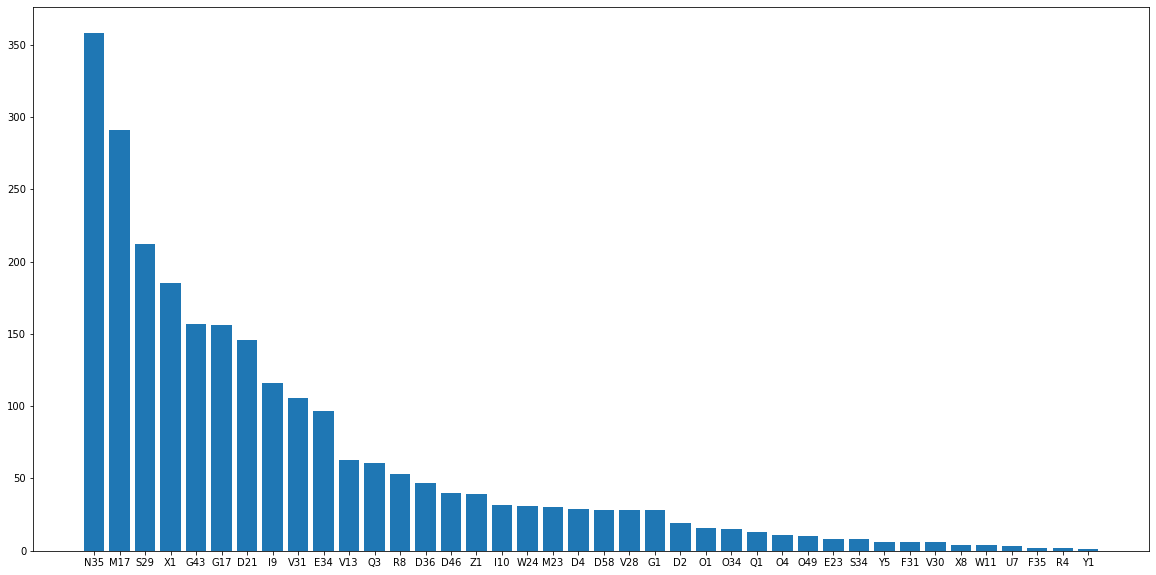

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({"Hieroglyph":hieroglyph_for_train, "Count":file_count_list})

df_sorted= df.sort_values('Count',ascending=False)

plt.figure(figsize=(20,10))
# make bar plot with matplotlib
plt.bar('Hieroglyph', 'Count',data=df_sorted)

In [12]:
# Number of images processed in a single training
batch_size = 20
num_workers = 0

# The load_data function is from hieroglyph_data_preparation python file
train_loader, test_loader, classes = load_data(data_dir)

ResNet Model

In [13]:
# Whether to extract features with the model
feature_extract = False
# Other selections
loss_function = "cross-entropy"
model_selection = "resnet-50"
optim_selection = "Adam"

# False if you want scratch model, True if you want pretrained model
whether_to_pretrain = False

# Load the model
if model_selection == "resnet-50":
    resnet50 = models.resnet50(pretrained=whether_to_pretrain)
    # Number of features in the last layer of resnet
    n_inputs = resnet50.fc.in_features
    # Add last linear layer (n_inputs -> 40 hieroglyph classes)
    last_layer = nn.Sequential(
                    nn.Linear(n_inputs, len(classes)))
    resnet50.fc = last_layer
    if train_on_gpu:
      resnet50.cuda()
    # Specify optimizer (Adam) and learning rate = 0.001
    if optim_selection == "Adam":
        optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

elif model_selection == "inception-v3":
    inception_v3 = models.inception_v3(pretrained=whether_to_pretrain)
    # Number of features in the last layer of resnet
    n_inputs = inception_v3.fc.in_features
    # Add last linear layer (n_inputs -> 40 hieroglyph classes)
    last_layer = nn.Sequential(
                    nn.Linear(n_inputs, len(classes)))
    inception_v3.fc = last_layer
    if train_on_gpu:
      inception_v3.cuda()
    # Specify optimizer (Adam) and learning rate = 0.001
    if optim_selection == "Adam":
        optimizer = optim.Adam(inception_v3.parameters(), lr=0.001)

elif model_selection == "xception":
    xception = timm.create_model('xception', pretrained=whether_to_pretrain)
    # Number of features in the last layer of resnet
    n_inputs = xception.fc.in_features
    # Add last linear layer (n_inputs -> 40 hieroglyph classes)
    last_layer = nn.Sequential(
                    nn.Linear(n_inputs, len(classes)))
    xception.fc = last_layer
    if train_on_gpu:
      xception.cuda()
    # Specify optimizer (Adam) and learning rate = 0.001
    if optim_selection == "Adam":
        optimizer = optim.Adam(xception.parameters(), lr=0.001)

# Specify loss function (categorical cross-entropy)
if loss_function == "cross-entropy":
    criterion = nn.CrossEntropyLoss()

# Exponential Decay to strengthen learning
decayRate = 0.999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

Training the model

In [14]:
# number of epochs to train the model
n_epochs = 50

if model_selection == "resnet-50":
  # The train_model function is from model_training python file
  resnet50, train_losses = train_model(train_loader, optimizer, resnet50, criterion, my_lr_scheduler, n_epochs)
elif model_selection == "inception-v3":
  # The train_model function is from model_training python file
  inception_v3, train_losses = train_model(train_loader, optimizer, inception_v3, criterion, my_lr_scheduler, n_epochs)
elif model_selection == "xception":
  # The train_model function is from model_training python file
  xception, train_losses = train_model(train_loader, optimizer, xception, criterion, my_lr_scheduler, n_epochs)

Epoch 1, Batch 20 loss: 4.1539815068244934
Epoch 1, Batch 40 loss: 3.2588010191917420
Epoch 1, Batch 60 loss: 2.8705749034881594
Epoch 1, Batch 80 loss: 2.7825077295303347
Epoch 1, Batch 100 loss: 2.5913107931613921
Epoch 1, Batch 120 loss: 2.4451573431491851
Epoch 2, Batch 20 loss: 2.0111468672752379
Epoch 2, Batch 40 loss: 1.9492158591747284
Epoch 2, Batch 60 loss: 1.9642651677131653
Epoch 2, Batch 80 loss: 1.9911817729473114
Epoch 2, Batch 100 loss: 1.4841841816902162
Epoch 2, Batch 120 loss: 1.3840274482965469
Epoch 3, Batch 20 loss: 1.3035962522029876
Epoch 3, Batch 40 loss: 1.1884049206972123
Epoch 3, Batch 60 loss: 1.1306664317846298
Epoch 3, Batch 80 loss: 1.1749210029840469
Epoch 3, Batch 100 loss: 1.1587682873010636
Epoch 3, Batch 120 loss: 1.1015463262796401
Epoch 4, Batch 20 loss: 0.9586393564939499
Epoch 4, Batch 40 loss: 0.8691994056105614
Epoch 4, Batch 60 loss: 0.9039113283157348
Epoch 4, Batch 80 loss: 0.8467815831303597
Epoch 4, Batch 100 loss: 0.8517379537224770
Epoc

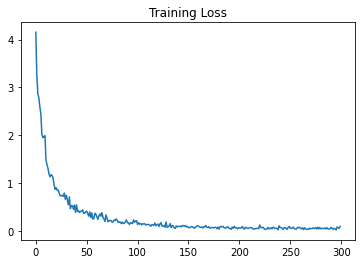

In [15]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

Testing the model

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [17]:
# The test_model function is from model_testing python file
test_loss, class_correct, class_total, labels, predictions = test_model(classes, resnet50, test_loader, criterion)

# Test accuracy for each hieroglyph
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Total Test accuracy
print("\nAccuracy: {:.3%}".format(accuracy_score(labels, predictions)))
print("\nPrecision: {:.3%}".format(precision_score(labels, predictions, average = 'weighted')))
print("\nRecall: {:.3%}".format(recall_score(labels, predictions, average = 'weighted')))
print("\nF1-score: {:.3%}".format(f1_score(labels, predictions, average = 'weighted')))

Test Loss: 0.193166

Test Accuracy of    D2: 100% (18/18)
Test Accuracy of   D21: 94% (18/19)
Test Accuracy of   D36: 77% ( 7/ 9)
Test Accuracy of    D4: 100% (11/11)
Test Accuracy of   D46: 76% (13/17)
Test Accuracy of   D58: 84% (16/19)
Test Accuracy of   E23: 73% (14/19)
Test Accuracy of   E34: 100% (16/16)
Test Accuracy of   F31: 100% (14/14)
Test Accuracy of   F35: 100% (13/13)
Test Accuracy of    G1: 87% (14/16)
Test Accuracy of   G17: 95% (20/21)
Test Accuracy of   G43: 100% (18/18)
Test Accuracy of   I10: 100% (18/18)
Test Accuracy of    I9: 100% (10/10)
Test Accuracy of   M17: 100% (18/18)
Test Accuracy of   M23: 100% (11/11)
Test Accuracy of   N35: 100% (20/20)
Test Accuracy of    O1: 100% (12/12)
Test Accuracy of   O34: 80% (17/21)
Test Accuracy of    O4: 100% (16/16)
Test Accuracy of   O49: 100% (13/13)
Test Accuracy of    Q1: 76% (13/17)
Test Accuracy of    Q3: 93% (15/16)
Test Accuracy of    R4: 100% (15/15)
Test Accuracy of    R8: 100% (12/12)
Test Accuracy of   S29: 100